# Analysis of already processed RU29 Nortek AD2CP velocity data

In [1]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw

import cmocean.cm as cmo

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


# Calculate rho from salinity, temperature, pressure, lon, lat
def gsw_rho(SP, T, P, lon, lat):
        # Calculates absolute salinity (g/kg) from PSU
        SA = gsw.SA_from_SP(SP, P, lon, lat)
        # in-situ density
        rho = gsw.density.rho_t_exact(SA, T, P)
        return rho
    
    
def profile_mld(mld_var='density', zvar='depth', qi_threshold=0.5):
    """
    Written by Sam Coakley and Lori Garzio, Jan 2022
    Calculates the Mixed Layer Depth (MLD) for a single profile as the depth of max Brunt‐Vaisala frequency squared
    (N**2) from Carvalho et al 2016
    :param mld_var: the name of the variable for which MLD is calculated, default is 'density'
    :param zvar: the name of the depth variable in the dataframe, default is 'pressure'
    :param qi_threshold: quality index threshold for determining well-mixed water, default is 0.5
    :return: the depth of the mixed layer in the units of zvar
    """
    pN2 = np.sqrt(9.81 / np.nanmean(mld_var) * np.diff(mld_var) / np.diff(zvar)) ** 2
    if np.sum(~np.isnan(pN2)) == 0:
        mld = np.nan
    else:
        mld_idx = np.where(pN2 == np.nanmax(pN2))[0][0]
        mld = np.nanmean([zvar[mld_idx], zvar[mld_idx + 1]])

        if mld_idx == 0:
            # if the code finds the first data point as the MLD, return nan
            mld = np.nan
        elif mld < 2:
            # if MLD is <2, return nan
            mld = np.nan
        else:
            if qi_threshold:
                # find MLD  1.5
                mld15 = mld * 1.5
                mld15_idx = np.argmin(np.abs(zvar - mld15))

                # Calculate Quality index (QI) from Lorbacher et al, 2006
                surface_mld_values = mld_var[0:mld_idx]  # values from the surface to MLD
                surface_mld15_values = mld_var[0:mld15_idx]  # values from the surface to MLD * 1.5

                qi = 1 - (np.std(surface_mld_values - np.nanmean(surface_mld_values)) /
                          np.std(surface_mld15_values - np.nanmean(surface_mld15_values)))

                if qi < qi_threshold:
                    # if the Quality Index is < the threshold, this indicates well-mixed water so don't return MLD
                    mld = np.nan

    return mld

# Load data files

### Glider data first, this was created on my local computer where I just loaded through all the dbds and only pulled out start time, end time, start lat, start lon, end lat, end lon, and the depth averaged velocities (vx and vy) from the end of the segment.

In [2]:
gl = pd.read_csv('/home/jg1200/Data/GliderData/RU29/RU29_2020_vx_vy_lat_lon.csv',usecols=[1,2,3,4,5,6,7,8])
gl.start_tm = np.array(gl.start_tm,dtype=np.datetime64)
gl.end_tm = np.array(gl.start_tm,dtype=np.datetime64)
gl

,start_tm,end_tm,start_lat,start_lon,end_lat,end_lon,end_vx,end_vy
0,2020-09-08 15:29:32.766754048,2020-09-08 15:29:32.766754048,18.170002,-64.796574,18.171467,-64.797777,-0.140862,0.115427
1,2020-09-08 16:24:48.429809664,2020-09-08 16:24:48.429809664,18.175290,-64.802942,18.176025,-64.802830,-0.074237,0.037482
2,2020-09-08 17:08:26.503631616,2020-09-08 17:08:26.503631616,18.176050,-64.802863,18.177313,-64.803195,-0.104293,0.060243
3,2020-09-08 17:52:08.479034368,2020-09-08 17:52:08.479034368,18.177320,-64.803227,18.177777,-64.803195,-0.073689,0.021219
4,2020-09-08 18:29:04.142639104,2020-09-08 18:29:04.142639104,18.177805,-64.803217,18.177313,-64.799267,-0.078872,0.025200
...,...,...,...,...,...,...,...,...
542,2020-11-16 06:46:20.681335552,2020-11-16 06:46:20.681335552,NaN,NaN,18.149488,-64.790730,-0.043635,-0.000011
543,2020-11-16 08:14:06.041015552,2020-11-16 08:14:06.041015552,NaN,NaN,18.160925,-64.788282,-0.032541,-0.012039
544,2020-11-16 09:38:16.354126080,2020-11-16 09:38:16.354126080,NaN,NaN,18.168160,-64.786373,0.002537,-0.010122
545,2020-11-16 11:05:57.337615872,2020-11-16 11:05:57.337615872,NaN,NaN,18.163325,-64.788422,-0.039627,0.010190


### Processed AD2CP data now

In [3]:
#fname = '/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion/Total/RU29_2020_AD2CP_10m_inversion_Total.nc'
#fname = '/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_5m/Total/RU29_2020_AD2CP_5m_inversion_Total.nc'

fname = '/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_5m/Total/RU29_2020_AD2CP_5m_Inversion_Total.nc'

#fname = '/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_Shear_Only_5m/Total/RU29_2020_AD2CP_5m_Inversion_Total_shear.nc'

df = xr.open_dataset(fname)
df['time'] = pd.to_datetime(df.time)
df = df.dropna(dim = 'time',how='all')
df

<xarray.Dataset>
Dimensions:     (depth: 201, time: 183)
Coordinates:
  * depth       (depth) float64 2.5 7.5 12.5 17.5 ... 992.5 997.5 1.002e+03
  * time        (time) datetime64[ns] 2020-10-15T03:06:57.784332288 ... 2020-...
Data variables:
    inverted_u  (depth, time) float64 -0.113 -0.08818 -0.04814 ... nan nan nan
    inverted_v  (depth, time) float64 -0.002478 0.02233 0.01062 ... nan nan nan

### Section timing

In [4]:
sect_times = pd.read_csv('/home/jg1200/Data/GliderData/RU29/anagada_section_times.csv')
sect_times.starttime = np.array(sect_times.starttime,dtype=np.datetime64)
sect_times.endtime = np.array(sect_times.endtime,dtype=np.datetime64)
sect_times

,section_number,starttime,endtime
0,0,2020-09-13 15:21:18,2020-09-15 06:58:35
1,1,2020-10-01 00:26:24,2020-10-03 00:46:16
2,2,2020-10-06 20:48:49,2020-10-08 13:48:27
3,3,2020-10-08 13:48:27,2020-10-10 13:04:46
4,4,2020-10-10 13:04:46,2020-10-12 02:23:15
5,5,2020-10-12 02:23:15,2020-10-13 21:10:42
6,6,2020-10-13 21:10:42,2020-10-15 09:07:30
7,7,2020-10-15 09:07:30,2020-10-17 00:31:58
8,8,2020-10-17 00:31:58,2020-10-18 13:53:20
9,9,2020-10-18 13:53:20,2020-10-20 06:44:54


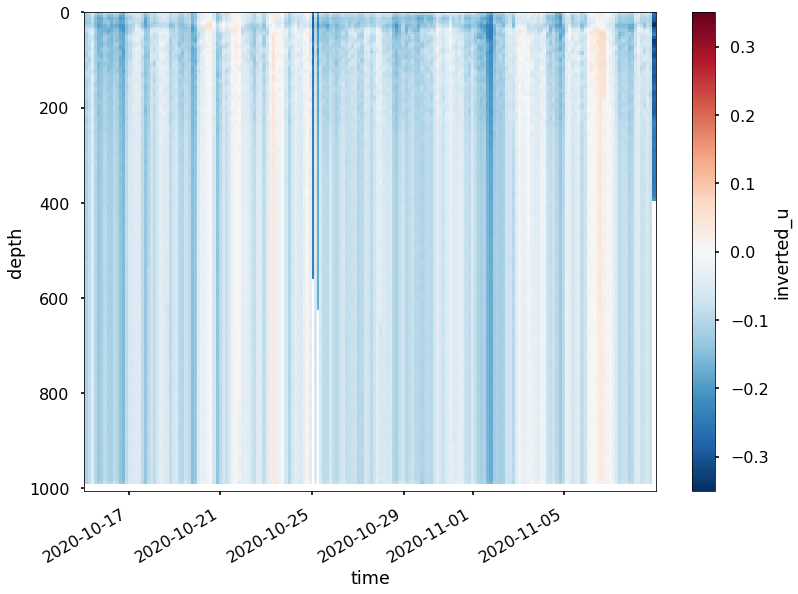

In [5]:
df.inverted_u.plot()
plt.gca().invert_yaxis()

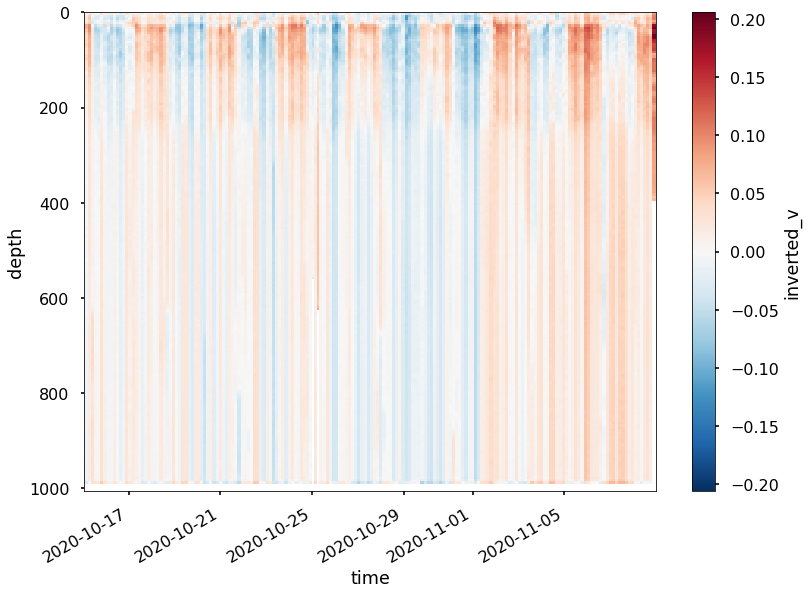

In [6]:
df.inverted_v.plot()
plt.gca().invert_yaxis()

## Make a grid for the mean position of the transects

In [7]:
start = 7
end   = 22

gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[start]) & (gl.end_tm.values < sect_times.endtime.values[end])]
gl_sect

,start_tm,end_tm,start_lat,start_lon,end_lat,end_lon,end_vx,end_vy
308,2020-10-15 09:56:31.907623168,2020-10-15 09:56:31.907623168,NaN,NaN,17.850142,-64.800513,-0.101187,-0.004297
309,2020-10-15 13:14:27.913940480,2020-10-15 13:14:27.913940480,NaN,NaN,17.879870,-64.803508,-0.133741,-0.006223
310,2020-10-15 16:37:21.079834112,2020-10-15 16:37:21.079834112,NaN,NaN,17.909808,-64.803287,-0.124540,0.021048
311,2020-10-15 19:56:07.751708928,2020-10-15 19:56:07.751708928,NaN,NaN,17.937273,-64.798527,-0.098883,0.002144
312,2020-10-15 23:15:44.873779200,2020-10-15 23:15:44.873779200,NaN,NaN,17.963138,-64.798580,-0.116723,-0.013080
...,...,...,...,...,...,...,...,...
484,2020-11-08 09:03:11.117675776,2020-11-08 09:03:11.117675776,NaN,NaN,18.055675,-64.791812,-0.073856,0.030824
485,2020-11-08 12:23:22.919189504,2020-11-08 12:23:22.919189504,NaN,NaN,18.027197,-64.791640,-0.056688,0.039648
486,2020-11-08 15:36:59.891418368,2020-11-08 15:36:59.891418368,NaN,NaN,17.997677,-64.794293,-0.078763,0.025109
487,2020-11-08 19:04:41.709899776,2020-11-08 19:04:41.709899776,NaN,NaN,17.968037,-64.797158,-0.104563,0.039625


Text(0.5, 1.0, 'Glider Surfacing Position During Transect')

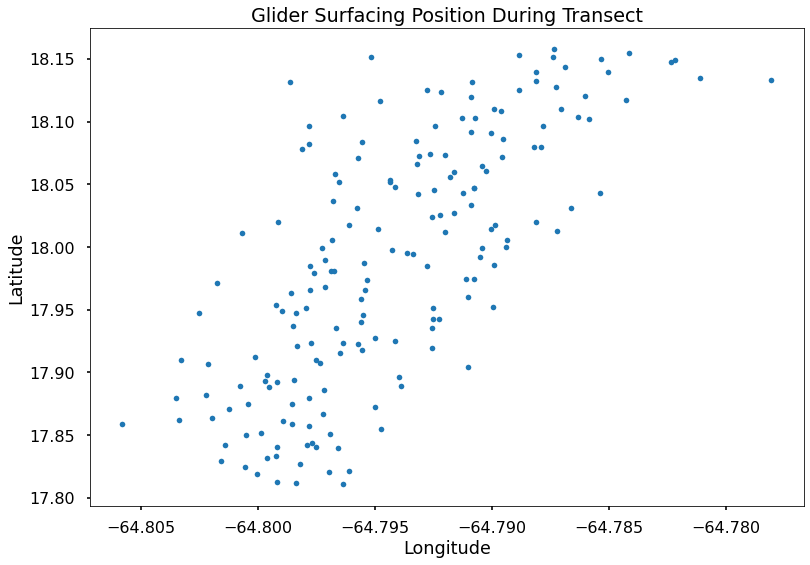

In [8]:
plt.plot(gl_sect.end_lon,gl_sect.end_lat,'.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Glider Surfacing Position During Transect')

In [9]:
lat_grid = np.arange(17.8,18.16,0.05)
lat_grid

array([17.8 , 17.85, 17.9 , 17.95, 18.  , 18.05, 18.1 , 18.15])

In [10]:
lon_grid = np.repeat(-64.80,8) # Just make it -64.80
lon_grid
#np.mean(gl_sect.end_lon)

array([-64.8, -64.8, -64.8, -64.8, -64.8, -64.8, -64.8, -64.8])

In [12]:
dep_grid = df.depth.values
dep_grid[0:10]

array([ 2.5,  7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5])

In [13]:
X, Y, Z = np.meshgrid(lon_grid, lat_grid, dep_grid)

In [14]:
x = 7
subset = df.sel(time=slice(sect_times.starttime.values[7], sect_times.endtime.values[22]))
subset

<xarray.Dataset>
Dimensions:     (depth: 201, time: 181)
Coordinates:
  * depth       (depth) float64 2.5 7.5 12.5 17.5 ... 992.5 997.5 1.002e+03
  * time        (time) datetime64[ns] 2020-10-15T09:43:41.071441664 ... 2020-...
Data variables:
    inverted_u  (depth, time) float64 -0.04814 -0.1052 -0.1358 ... nan nan nan
    inverted_v  (depth, time) float64 0.01062 -0.0005705 -0.002701 ... nan nan

In [15]:
x = 7
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]
gl_sect

,start_tm,end_tm,start_lat,start_lon,end_lat,end_lon,end_vx,end_vy
308,2020-10-15 09:56:31.907623168,2020-10-15 09:56:31.907623168,NaN,NaN,17.850142,-64.800513,-0.101187,-0.004297
309,2020-10-15 13:14:27.913940480,2020-10-15 13:14:27.913940480,NaN,NaN,17.879870,-64.803508,-0.133741,-0.006223
310,2020-10-15 16:37:21.079834112,2020-10-15 16:37:21.079834112,NaN,NaN,17.909808,-64.803287,-0.124540,0.021048
311,2020-10-15 19:56:07.751708928,2020-10-15 19:56:07.751708928,NaN,NaN,17.937273,-64.798527,-0.098883,0.002144
312,2020-10-15 23:15:44.873779200,2020-10-15 23:15:44.873779200,NaN,NaN,17.963138,-64.798580,-0.116723,-0.013080
313,2020-10-16 02:30:01.632354816,2020-10-16 02:30:01.632354816,NaN,NaN,17.987487,-64.795465,-0.119837,-0.013422
314,2020-10-16 05:44:49.512420608,2020-10-16 05:44:49.512420608,NaN,NaN,18.014355,-64.790067,-0.098321,0.005854
315,2020-10-16 08:58:31.072204544,2020-10-16 08:58:31.072204544,NaN,NaN,18.043118,-64.791250,-0.108684,-0.011559
316,2020-10-16 12:20:36.411468544,2020-10-16 12:20:36.411468544,NaN,NaN,18.071100,-64.795715,-0.142399,-0.024271
317,2020-10-16 15:34:23.425567744,2020-10-16 15:34:23.425567744,NaN,NaN,18.096282,-64.797817,-0.155180,-0.014253


In [243]:
## This works for one transect
gridvelu = np.empty((subset.inverted_u.shape[0],len(lat_grid),15))
gridvelu[:] = np.NaN
gridvelv = np.empty((subset.inverted_u.shape[0],len(lat_grid),15))
gridvelv[:] = np.NaN


## The last profile is kind of weird so only doing 0:15, not 0:16
for y in np.arange(0,15):
    z = np.arange(7,23)
    subset = df.sel(time=slice(sect_times.starttime.values[z[y]], sect_times.endtime.values[z[y]]))
    gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[z[y]]) & (gl.end_tm.values < sect_times.endtime.values[z[y]])]

    for x in np.arange(0,subset.inverted_u.shape[0]):
        gridvelu[x,:,y] = interp.griddata(gl_sect.end_lat, subset.inverted_u[x,:], lat_grid, method='nearest')
        gridvelv[x,:,y] = interp.griddata(gl_sect.end_lat, subset.inverted_v[x,:], lat_grid, method='nearest')

        
meangridu = np.nanmean(gridvelu,axis=2)
meangridv = np.nanmean(gridvelv,axis=2)
stdgridu  = np.nanstd(gridvelu, axis=2)
stdgridv  = np.nanstd(gridvelv, axis=2)


/tmp/ipykernel_14514/4029667254.py:19: RuntimeWarning: Mean of empty slice
  meangridu = np.nanmean(gridvelu,axis=2)
/tmp/ipykernel_14514/4029667254.py:20: RuntimeWarning: Mean of empty slice
  meangridv = np.nanmean(gridvelv,axis=2)
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


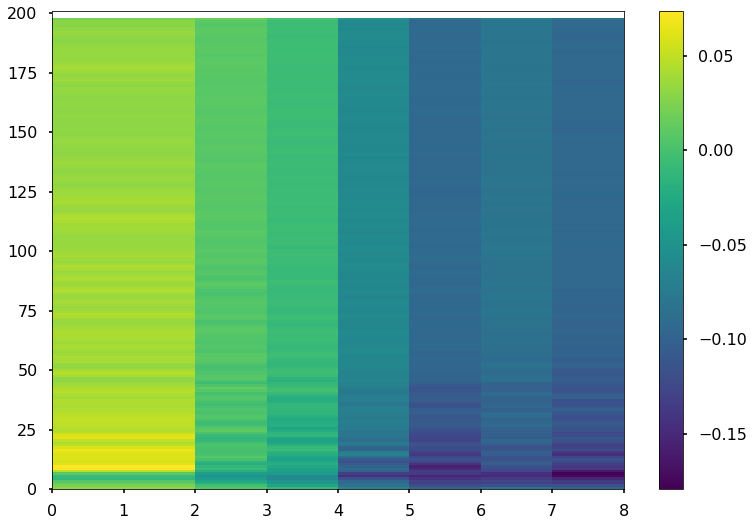

In [245]:
plt.pcolormesh(gridvelu[:,:,14])
plt.colorbar()

In [265]:
np.nanmax(meangridv)

0.04665166617335789

Text(0.5, 1.0, 'Temporal Mean Velocity')

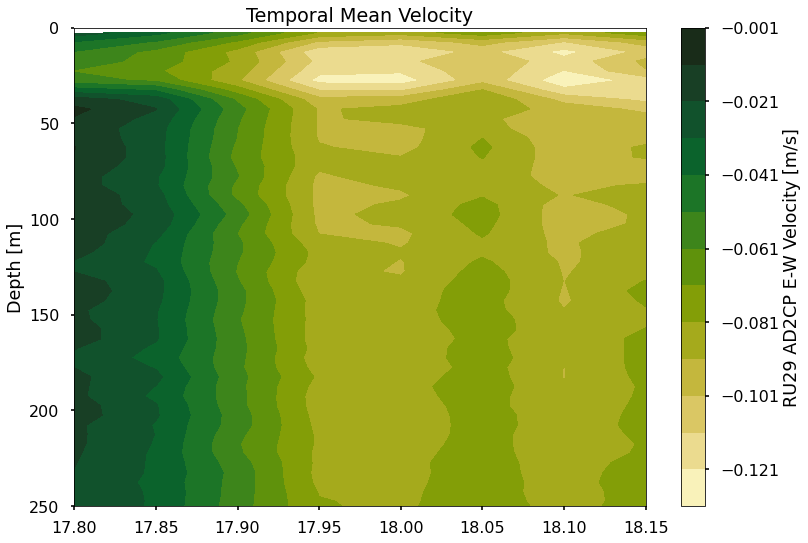

In [263]:
plt.contourf(lat_grid,subset.depth.values,meangridu,cmap=cmo.speed,levels=np.arange(-0.131, 0, 0.01))
plt.gca().invert_yaxis()
plt.ylim(250,0)
plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
plt.ylabel('Depth [m]')
plt.title('Temporal Mean Velocity')

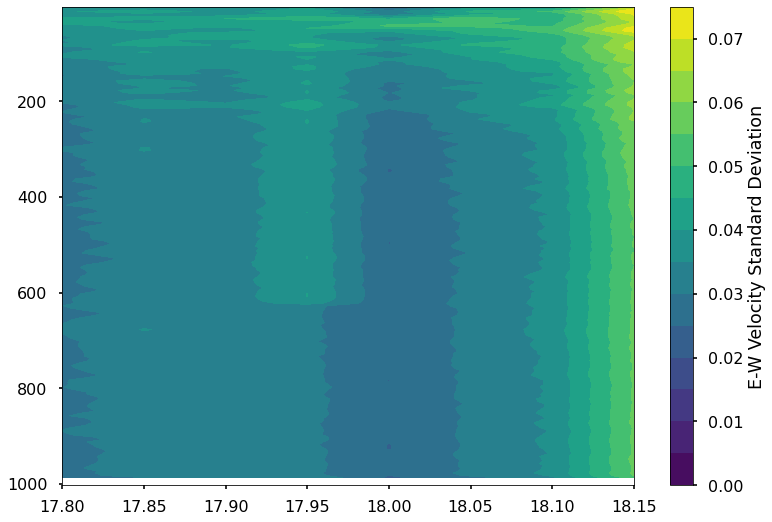

In [274]:
plt.contourf(lat_grid,subset.depth.values,stdgridu,levels=np.arange(0, 0.076, 0.005))
plt.colorbar(label='E-W Velocity Standard Deviation')
plt.gca().invert_yaxis()
#plt.ylim(250,0)


Text(0.5, 1.0, 'Temporal Mean Velocity')

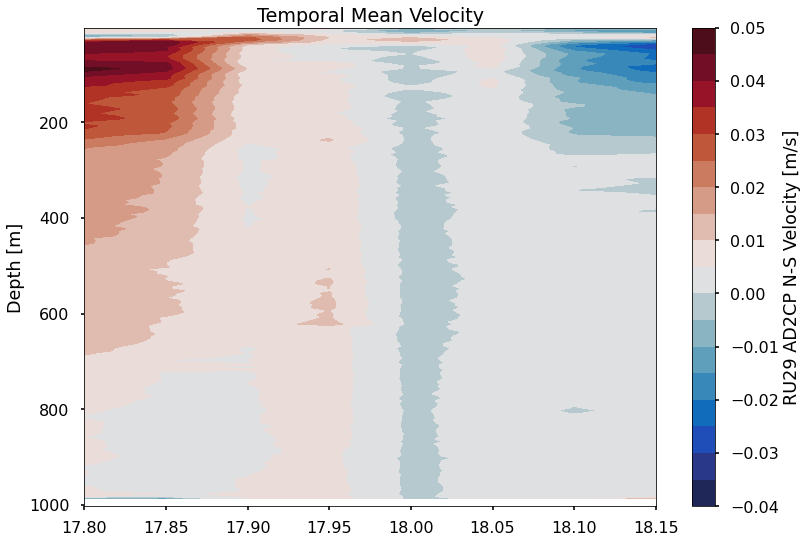

In [279]:
plt.contourf(lat_grid,subset.depth.values,meangridv,cmap=cmo.balance,levels=np.arange(-0.04, 0.051, 0.005))
plt.gca().invert_yaxis()
#plt.ylim(250,0)
plt.colorbar(label='RU29 AD2CP N-S Velocity [m/s]');
plt.ylabel('Depth [m]')
plt.title('Temporal Mean Velocity')

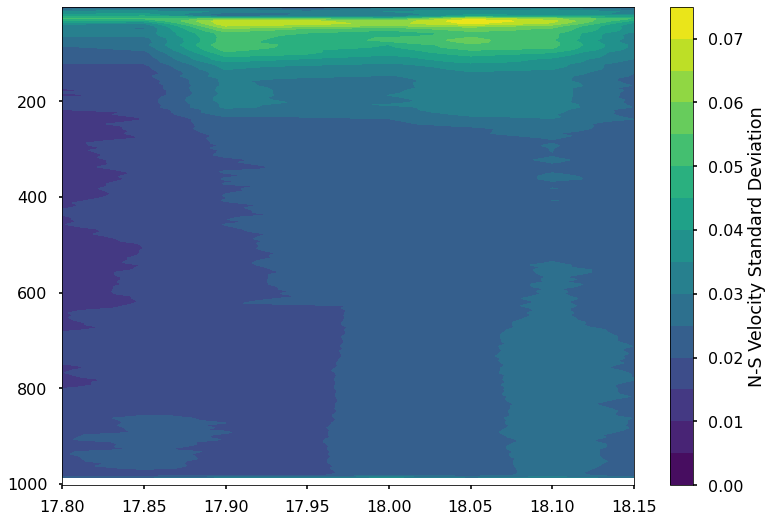

In [253]:
plt.contourf(lat_grid,subset.depth.values,stdgridv,levels=np.arange(0, 0.076, 0.005))
plt.colorbar(label='N-S Velocity Standard Deviation')
plt.gca().invert_yaxis()
#plt.ylim(250,0)


# Calculate Transport!

In [299]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(lat_grid[0])
lon1 = radians(lon_grid[0])
lat2 = radians(lat_grid[1])
lon2 = radians(lon_grid[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

5561.491661480293

In [283]:
transport_gridu = np.empty(gridvelu.shape[2])
transport_gridv = np.empty(gridvelu.shape[2])

for x in np.arange(0,gridvelu.shape[2]):
    transport_gridu[x] = (np.nansum(gridvelu[:,:,x]*5*distance))/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
    transport_gridv[x] = (np.nansum(gridvelv[:,:,x]*5*distance))/(10**6) # multiply by 5 because of grid cell size


In [326]:
#np.nanmean(transport_gridu)
#np.nanstd(transport_gridu)

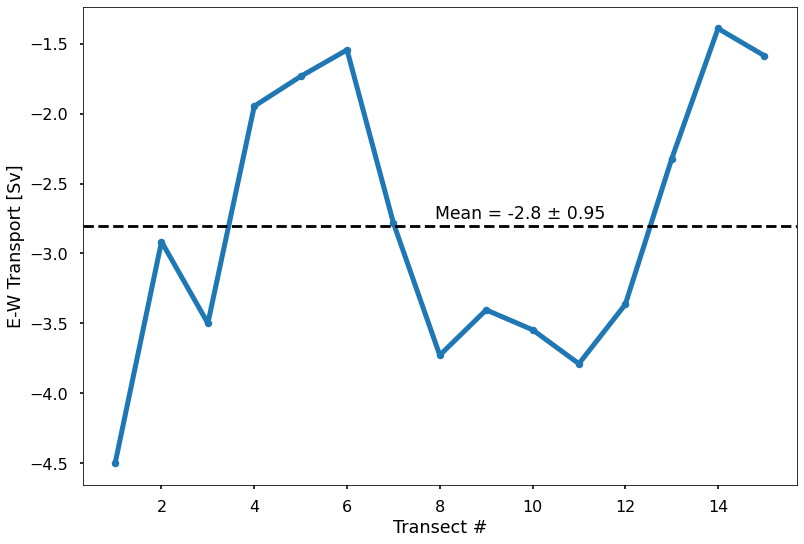

In [370]:
plt.plot(np.arange(1,16),transport_gridu, linewidth=5,color='tab:blue')

# for x in np.arange(1,15,2):
#     z = np.arange(7,22)
#     plt.text(x+0.1,transport_gridu[x]-0.05,"%s" % str(sect_times.starttime.values[z[x]])[0:10])

plt.plot(np.arange(1,16),transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.axhline(y=np.nanmean(transport_gridu), color='k', linestyle='--')
plt.text(7.9, np.nanmean(transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridu),2),np.round(np.nanstd(transport_gridu),2)), fontsize = 'xx-large');





In [287]:
## Back of the envelope DAC based on transport
(3*(10**6))/(1000*38000)

0.07894736842105263

Text(7, 0.248692611914669, 'Mean = 0.22 ± 0.56')

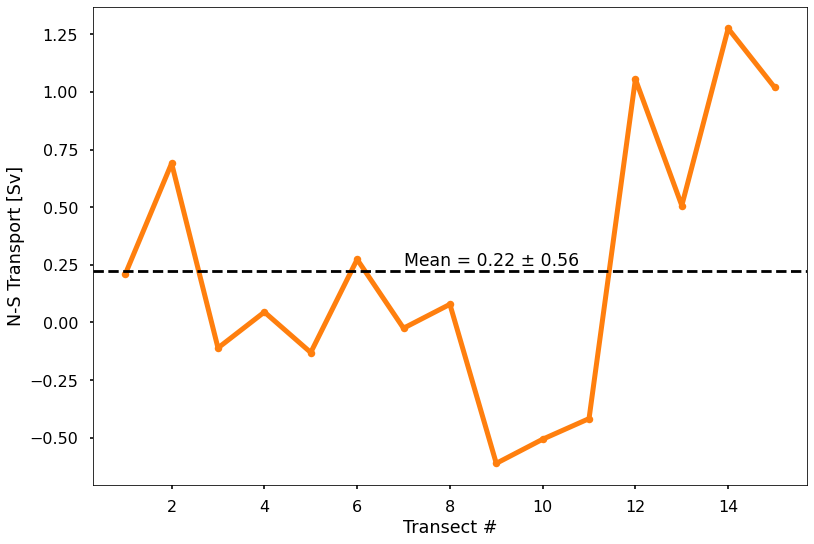

In [330]:
plt.plot(np.arange(1,16),transport_gridv, linewidth=5,color='tab:orange')
plt.plot(np.arange(1,16),transport_gridv, '.',color='tab:orange',markersize=15)
plt.ylabel('N-S Transport [Sv]')
plt.xlabel('Transect #')
plt.axhline(y=np.nanmean(transport_gridv), color='k', linestyle='--')
plt.text(7, np.nanmean(transport_gridv)+0.025, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridv),2),np.round(np.nanstd(transport_gridv),2)), fontsize = 'xx-large')




## Try to plot in loop now

In [28]:
# #x=9
# for x in np.arange(7,len(sect_times)):
#     subset = df.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))
#     gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]

#     plt.clf() 
#     ## Plot U Velocity
#     plt.pcolormesh(gl_sect.end_lat,subset.depth,subset.inverted_u,vmin=-0.2,vmax=0.2,cmap='RdBu')
#     plt.gca().invert_yaxis();
#     plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
#     plt.title('Start: %s \nEnd: %s' %(str(subset.time[0].values),str(subset.time[-1].values)));
#     plt.ylabel('Depth [m]');
#     plt.xlabel('Latitude');
#     plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections/RU29_2020_U_Velocity_Section_{}.png'.format(x);
#     plt.savefig(plotname, dpi = 300);
    
#     plt.clf() 
#     ## Plot V Velocity
#     plt.pcolormesh(gl_sect.end_lat,subset.depth,subset.inverted_v,vmin=-0.1,vmax=0.1,cmap='RdBu');
#     plt.gca().invert_yaxis();
#     plt.colorbar(label='RU29 AD2CP N-S Velocity [m/s]');
#     plt.title('Start: %s \nEnd: %s' %(str(subset.time[0].values),str(subset.time[-1].values)));
#     plt.ylabel('Depth [m]');
#     plt.xlabel('Latitude');
#     plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections/RU29_2020_V_Velocity_Section_{}.png'.format(x);
#     plt.savefig(plotname, dpi = 300);




In [11]:
subset.time.values

array(['2020-10-15T09:43:41.071441664', '2020-10-15T13:01:03.655517696',
       '2020-10-15T16:24:03.857635584', '2020-10-15T19:43:34.960449280',
       '2020-10-15T23:02:06.639617792', '2020-10-16T02:16:33.664550656',
       '2020-10-16T05:32:36.824249344', '2020-10-16T08:51:57.199890176',
       '2020-10-16T11:58:34.363006464', '2020-10-16T15:21:32.647003136',
       '2020-10-16T18:38:13.830871552', '2020-10-16T21:51:48.294433536'],
      dtype='datetime64[ns]')

## Test out some smoothing...

/tmp/ipykernel_19541/2595051611.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18,10))


<Figure size 921.6x633.6 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

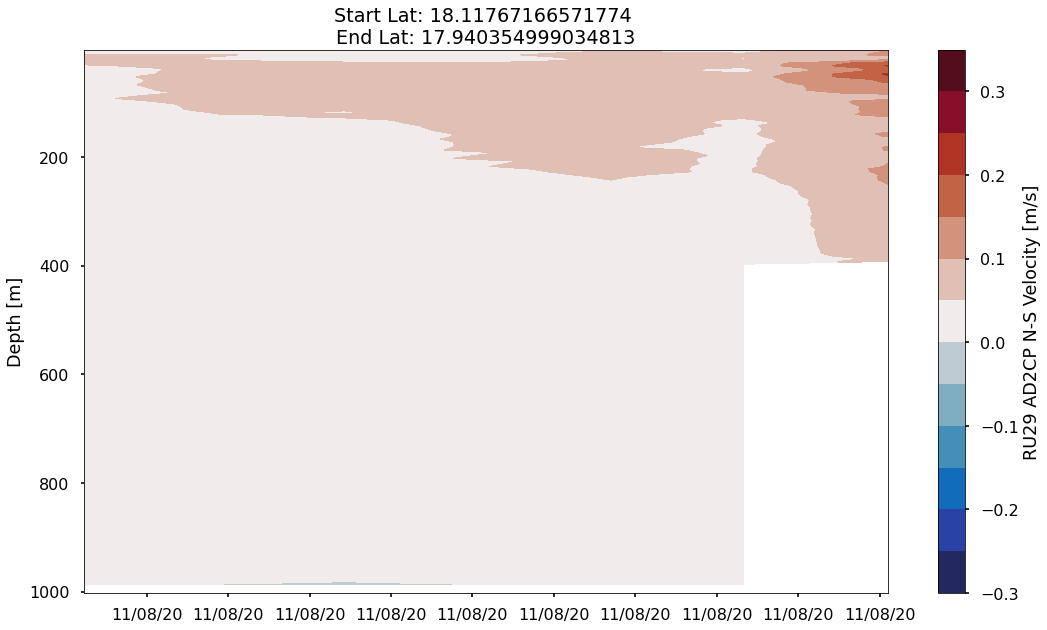

In [50]:
# #x=9
# for x in np.arange(7,len(sect_times)):
#     subset = df.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))
#     gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]

#     plt.clf() 
#     ## Plot U Velocity
#     plt.pcolormesh(gl_sect.end_lat,subset.depth,subset.inverted_u,vmin=-0.2,vmax=0.2,cmap='RdBu',shading='gouraud')
#     plt.gca().invert_yaxis();
#     plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
#     plt.title('Start: %s \nEnd: %s' %(str(subset.time[0].values),str(subset.time[-1].values)));
#     plt.ylabel('Depth [m]');
#     plt.xlabel('Latitude');
#     plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_smoothed/RU29_2020_U_Velocity_Section_{}_smoothed.png'.format(x);
#     plt.savefig(plotname, dpi = 300);
    
#     plt.clf() 
#     ## Plot V Velocity
#     plt.pcolormesh(gl_sect.end_lat,subset.depth,subset.inverted_v,vmin=-0.1,vmax=0.1,cmap='RdBu',shading='gouraud');
#     plt.gca().invert_yaxis();
#     plt.colorbar(label='RU29 AD2CP N-S Velocity [m/s]');
#     plt.title('Start: %s \nEnd: %s' %(str(subset.time[0].values),str(subset.time[-1].values)));
#     plt.ylabel('Depth [m]');
#     plt.xlabel('Latitude');
#     plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_smoothed/RU29_2020_V_Velocity_Section_{}_smoothed.png'.format(x);
#     plt.savefig(plotname, dpi = 300);




x=7

#for x in np.arange(7,len(sect_times)):
subset = df.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]

# plt.clf() 
# ## Plot U Velocity
# plt.pcolormesh(gl_sect.end_lat,subset.depth,subset.inverted_u,vmin=-0.2,vmax=0.2,cmap='RdBu',shading='gouraud')
# plt.gca().invert_yaxis();
# plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
# plt.title('Start: %s \nEnd: %s' %(str(subset.time[0].values),str(subset.time[-1].values)));
# plt.ylabel('Depth [m]');
# plt.xlabel('Latitude');
# plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_smoothed/RU29_2020_U_Velocity_Section_{}_smoothed.png'.format(x);
# plt.savefig(plotname, dpi = 300);

# plt.clf() 
# ## Plot V Velocity
# plt.pcolormesh(gl_sect.end_lat,subset.depth,subset.inverted_v,vmin=-0.1,vmax=0.1,cmap='RdBu',shading='gouraud');
# plt.gca().invert_yaxis();
# plt.colorbar(label='RU29 AD2CP N-S Velocity [m/s]');
# plt.title('Start: %s \nEnd: %s' %(str(subset.time[0].values),str(subset.time[-1].values)));
# plt.ylabel('Depth [m]');
# plt.xlabel('Latitude');
# plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_smoothed/RU29_2020_V_Velocity_Section_{}_smoothed.png'.format(x);
# plt.savefig(plotname, dpi = 300);





for x in np.arange(7,len(sect_times)):
    subset = df.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))
    gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]

    plt.clf() 
    ## Plot U Velocity
    plt.figure(figsize=(18,10))
    #plt.pcolormesh(subset.time.values, subset.depth, subset.inverted_u, vmin=-0.3,vmax=0.3,cmap='RdBu_r',shading='gouraud')
    plt.contourf(subset.time.values, subset.depth, subset.inverted_u, cmap=cmo.balance ,levels=np.arange(-0.3, 0.4, 0.05))
    plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
    plt.gca().invert_yaxis()
    plt.title('Start Lat: %s \nEnd Lat: %s' %(gl_sect.end_lat.values[0],gl_sect.end_lat.values[-1]))
    plt.ylabel('Depth [m]')
    plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_smoothed/RU29_2020_U_Velocity_Section_{}_smoothed.png'.format(x);
    plt.savefig(plotname, dpi = 300);
    plt.gca().xaxis.set_major_formatter(myFmt)

    
    plt.clf() 
    ## Plot V Velocity
    plt.figure(figsize=(18,10))
    #plt.pcolormesh(subset.time.values, subset.depth, subset.inverted_v, vmin=-0.3,vmax=0.3,cmap='RdBu_r',shading='gouraud')
    plt.contourf(subset.time.values, subset.depth, subset.inverted_v,cmap=cmo.balance,levels=np.arange(-0.3, 0.4, 0.05))
    plt.colorbar(label='RU29 AD2CP N-S Velocity [m/s]');
    plt.gca().invert_yaxis()
    plt.title('Start Lat: %s \nEnd Lat: %s' %(gl_sect.end_lat.values[0],gl_sect.end_lat.values[-1]))
    plt.ylabel('Depth [m]')
    plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_smoothed/RU29_2020_V_Velocity_Section_{}_smoothed.png'.format(x);
    plt.savefig(plotname, dpi = 300);
    plt.gca().xaxis.set_major_formatter(myFmt)





## Plotting without latitude

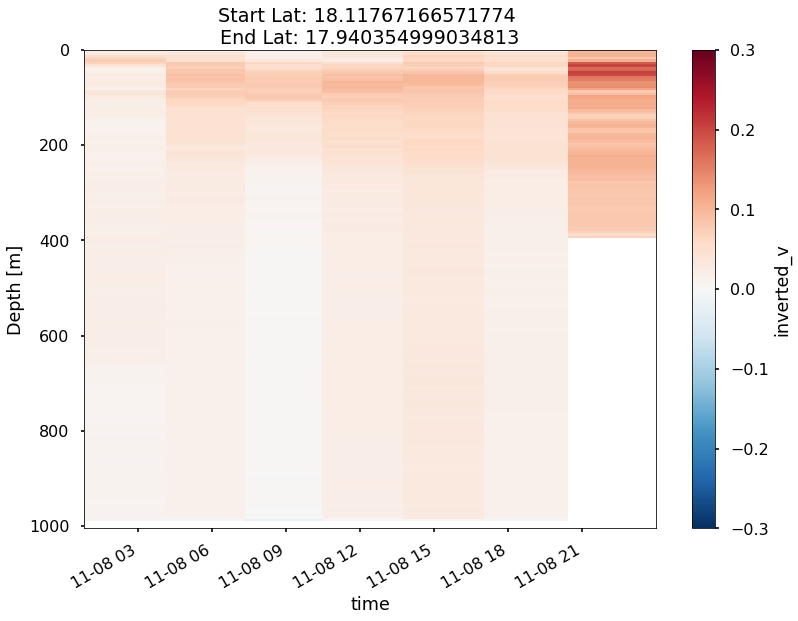

In [30]:
#x=9
for x in np.arange(7,len(sect_times)):
    subset = df.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))
    gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]

    plt.clf() 
    ## Plot U Velocity
    subset.inverted_u.plot(vmin=-0.3,vmax=0.3,cmap='RdBu_r')
    plt.gca().invert_yaxis()
    plt.title('Start Lat: %s \nEnd Lat: %s' %(gl_sect.end_lat.values[0],gl_sect.end_lat.values[-1]))
    plt.ylabel('Depth [m]')
    
    plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_no_latitude/RU29_2020_U_Velocity_Section_{}_no_lat.png'.format(x);
    #plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_5m_Shear_Only/RU29_2020_U_Velocity_Section_{}_shear.png'.format(x);
    plt.savefig(plotname, dpi = 300);
    plt.clf() 
    ## Plot V Velocity
    subset.inverted_v.plot(vmin=-0.3,vmax=0.3,cmap='RdBu_r')
    plt.gca().invert_yaxis()
    plt.title('Start Lat: %s \nEnd Lat: %s' %(gl_sect.end_lat.values[0],gl_sect.end_lat.values[-1]))
    plt.ylabel('Depth [m]')
    plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_no_latitude/RU29_2020_V_Velocity_Section_{}_no_lat.png'.format(x);
    #plotname = '/home/jg1200/Figures/RU29/2020_Processed_AD2CP_Sections_5m_Shear_Only/RU29_2020_V_Velocity_Section_{}_shear.png'.format(x);
    plt.savefig(plotname, dpi = 300);



# Pull out just one profile and look at in depth

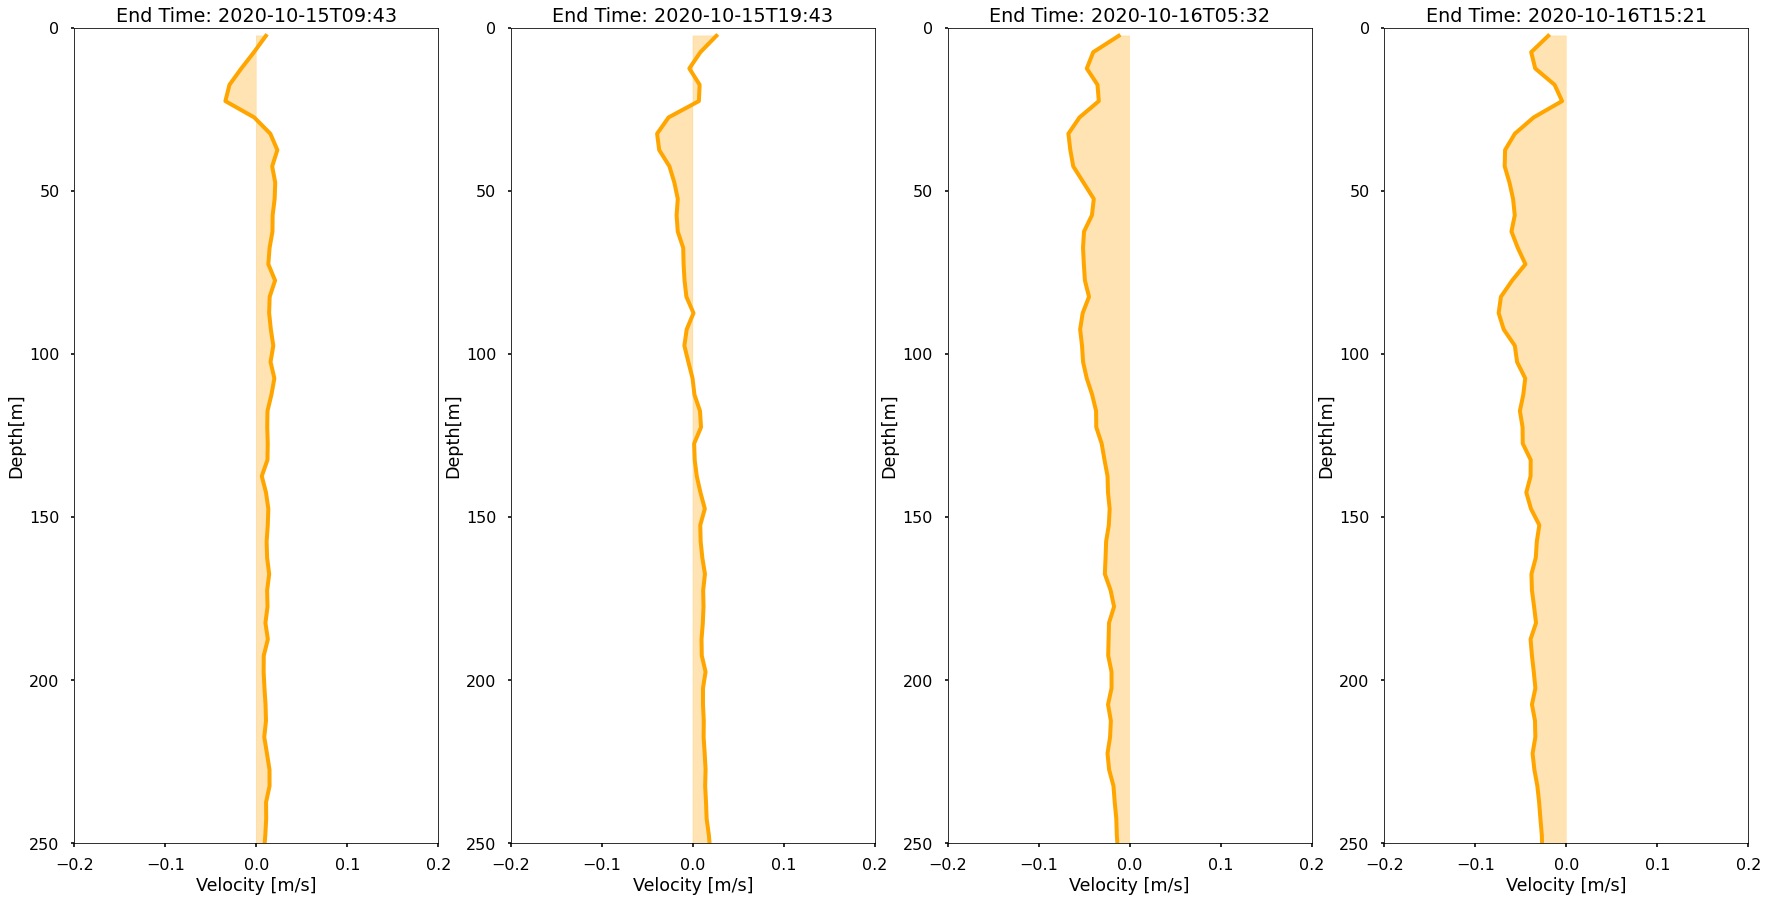

In [41]:
#x = 11
x =7

subset = df.sel(time=slice(sect_times.starttime.values[x], sect_times.endtime.values[x]))
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[x]) & (gl.end_tm.values < sect_times.endtime.values[x])]

    
fig, axs = plt.subplots(1,4, figsize=(30, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()


counter = 0
for x in np.arange(0,12,3):


    #axs[counter].plot(subset.inverted_u[:,x], subset.depth,linewidth=8)    
    #axs[counter].fill_betweenx(subset.depth, 0,subset.inverted_u[:,x], alpha=0.3)


    axs[counter].plot(subset.inverted_v[:,x], subset.depth,linewidth=4, color='orange')    
    axs[counter].fill_betweenx(subset.depth, 0,subset.inverted_v[:,x], alpha=0.3,color='orange')


    
    #axs[counter].plot(subset.inverted_v[:,x], subset.depth, label='N-S Velocity')
    axs[counter].set_xlabel('Velocity [m/s]')
    axs[counter].set_ylabel('Depth[m]')
    #axs[counter].set_ylim(1010,0)
    axs[counter].set_ylim(250,0)
    #axs[counter].legend(loc = 'lower right',frameon=False)
    axs[counter].set_xticks([-0.2,-0.1,0,0.1,0.2])
    axs[counter].set_title('End Time: %s' %str(subset.time.values[x])[0:16])

    counter = counter+1

    


    

## Glider science data now

In [2]:
def grid_glider_data(df, varname, delta_z=.3):
    """
    Written by aristizabal. Returns a gridded glider dataset by depth and time
    """
    df.dropna(inplace=True)
    df.drop(df[df['depth'] < .1].index, inplace=True)  # drop rows where depth is <1
    df.drop(df[df[varname] == 0].index, inplace=True)  # drop rows where the variable equals zero
    df.sort_values(by=['time', 'depth'], inplace=True)

    # find unique times and coordinates
    timeg, ind = np.unique(df.time.values, return_index=True)
    latg = df['latitude'].values[ind]
    long = df['longitude'].values[ind]
    dg = df['depth'].values
    vg = df[varname].values
    zn = np.int(np.max(np.diff(np.hstack([ind, len(dg)]))))

    depthg = np.empty((zn, len(timeg)))
    depthg[:] = np.nan
    varg = np.empty((zn, len(timeg)))
    varg[:] = np.nan

    for i, ii in enumerate(ind):
        if i < len(timeg) - 1:
            i_f = ind[i + 1]
        else:
            i_f = len(dg)
        depthi = dg[ind[i]:i_f]
        vari = vg[ind[i]:i_f]
        depthg[0:len(dg[ind[i]:i_f]), i] = depthi
        varg[0:len(vg[ind[i]:i_f]), i] = vari

    # sort time variable
    okt = np.argsort(timeg)
    timegg = timeg[okt]
    depthgg = depthg[:, okt]
    vargg = varg[:, okt]

    # Grid variables
    depthg_gridded = np.arange(0, np.nanmax(depthgg), delta_z)
    varg_gridded = np.empty((len(depthg_gridded), len(timegg)))
    varg_gridded[:] = np.nan

    for t, tt in enumerate(timegg):
        depthu, oku = np.unique(depthgg[:, t], return_index=True)
        varu = vargg[oku, t]
        okdd = np.isfinite(depthu)
        depthf = depthu[okdd]
        varf = varu[okdd]
        ok = np.asarray(np.isfinite(varf))
        if np.sum(ok) < 3:
            varg_gridded[:, t] = np.nan
        else:
            okd = np.logical_and(depthg_gridded >= np.min(depthf[ok]), depthg_gridded < np.max(depthf[ok]))
            varg_gridded[okd, t] = np.interp(depthg_gridded[okd], depthf[ok], varf[ok])

    return timegg, long, latg, depthg_gridded, varg_gridded



def get_erddap_dataset(ds_id, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server='https://data.ioos.us/gliders/erddap',
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        ds = e.to_pandas().dropna()
        #ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds



## These next two things work well!!

In [14]:
#ds_id = 'ru29-20200908T1623' ## Use this one
#ds_id = 'ru29-20210630T1343'

ds_id = 'ru29-20210908T1943'


variables = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'salinity', 'density','profile_id']

## To use this, need to add        ds = e.to_pandas().dropna(how='all') to get_erddap_dataset()
#variables = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'salinity', 'density','profile_id','measured_water_vx','measured_water_vy']

glider_df = get_erddap_dataset(ds_id, variables = variables, filetype='dataframe')
glider_df.columns = variables
glider_df



,depth,latitude,longitude,time,temperature,salinity,density,profile_id
0,5.735285,18.172007,-64.969040,2021-09-08T19:50:09Z,29.4667,34.811195,1021.79060,1631130606
1,8.329529,18.172007,-64.969040,2021-09-08T19:50:09Z,29.4456,34.849422,1021.83750,1631130606
2,11.043014,18.172007,-64.969040,2021-09-08T19:50:09Z,29.4329,34.874240,1021.87213,1631130606
3,13.756462,18.172007,-64.969040,2021-09-08T19:50:09Z,29.3618,34.890060,1021.91960,1631130606
4,16.489754,18.172007,-64.969040,2021-09-08T19:50:09Z,29.3146,34.879955,1021.93970,1631130606
...,...,...,...,...,...,...,...,...
257924,9.154515,18.162997,-64.814431,2021-10-07T17:10:11Z,29.4464,34.404920,1021.50750,1633626613
257925,8.120802,18.162997,-64.814431,2021-10-07T17:10:11Z,29.4702,34.403843,1021.49420,1633626613
257926,7.106961,18.162997,-64.814431,2021-10-07T17:10:11Z,29.4905,34.396755,1021.47766,1633626613
257928,6.023539,18.162997,-64.814431,2021-10-07T17:10:11Z,29.4995,34.406210,1021.47705,1633626613


In [15]:
# ind = np.where(np.isnan(glider_df.measured_water_vx)==False)
# #ind[0].flatten()
# glider_df.loc[ind[0]]

In [16]:
gl_tm, gl_lon, gl_lat, gl_depth, gl_temp = grid_glider_data(glider_df, 'temperature', 0.5)
gl_tm, gl_lon, gl_lat, gl_depth, gl_salinity = grid_glider_data(glider_df, 'salinity', 0.5)
gl_tm, gl_lon, gl_lat, gl_depth, gl_density = grid_glider_data(glider_df, 'density', 0.5)


/tmp/ipykernel_27156/1023127606.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zn = np.int(np.max(np.diff(np.hstack([ind, len(dg)]))))


#### Plotting for Travis Presentation

/tmp/ipykernel_27156/2962394897.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(pd.to_datetime(gl_tm),gl_depth,gl_temp,cmap=cmo.thermal)


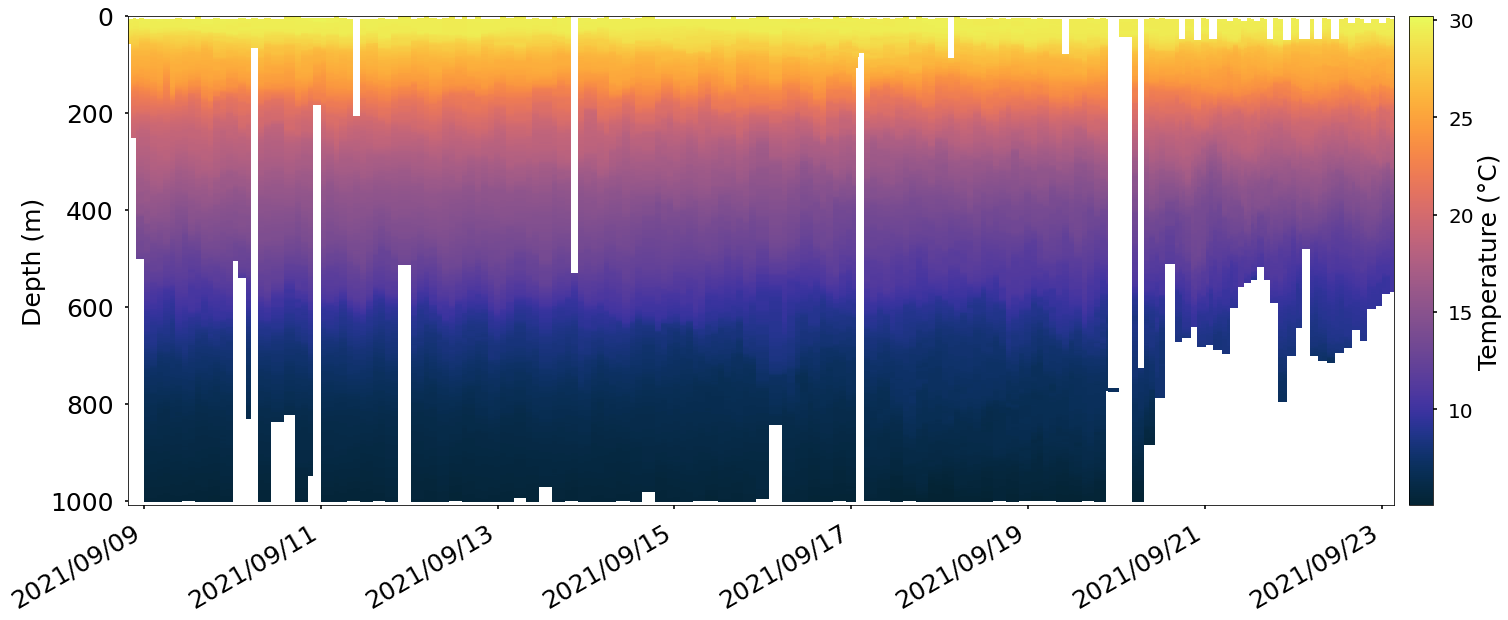

In [86]:
#plt.pcolormesh(gl_tm, gl_depth,gl_temp,cmap=cmo.thermal)

from matplotlib.dates import DateFormatter
import matplotlib
plt.rcParams.update({'font.size': 25})


myFmt = mdates.DateFormatter('%Y/%m/%d')

plt.figure(figsize=(27,10))
plt.pcolormesh(pd.to_datetime(gl_tm),gl_depth,gl_temp,cmap=cmo.thermal)

cbar = plt.colorbar(pad=0.01)
cbar.set_label(label='Temperature (°C)',size=25)
cbar.ax.tick_params(labelsize=20) 

plt.ylabel('Depth (m)', fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylim(1010,0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.xlim(pd.to_datetime(gl_tm[0]),pd.to_datetime(gl_tm[220]))

plt.show()


/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


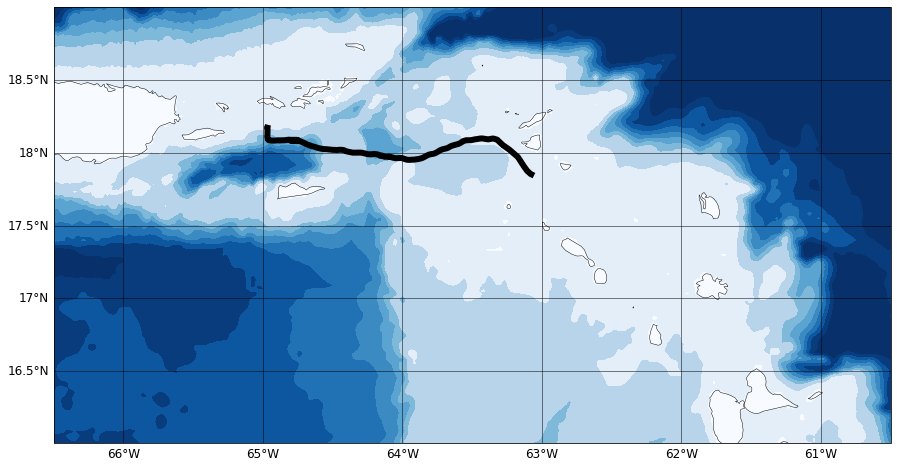

In [52]:
# grab bathymetry data for a map
import cartopy.crs as ccrs

## Zoomed window
lat_lims = [16, 19]
lon_lims = [-66.5, -60.5]


# grab some bathymetry
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

fig = plt.figure(figsize=(15,20))
ax = plt.subplot( projection= ccrs.Mercator())

## Good but too smooth
#dpth_contours = np.arange(-8500, 1, 500)

dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 
plt.plot(gl_lon[0:220], gl_lat[0:220], 'k',linewidth=6, 
         transform=ccrs.PlateCarree())


plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
#plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.055)
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# gl.xlocator = mticker.FixedLocator(np.arange(np.min(lon_lims), np.max(lon_lims), 1/12))
# gl.ylocator = mticker.FixedLocator(np.arange(np.min(lat_lims), np.max(lat_lims), 1/12))


## GOD This was hard to figure out time indexing between the two datasets but this works!

In [96]:
x =7 ### This is the transect I sent Mike Smith

tm_ind = np.where((pd.to_datetime(gl_tm).tz_localize(None) >= sect_times.starttime.values[x]) & (pd.to_datetime(gl_tm).tz_localize(None) <= sect_times.endtime.values[x]))
tm_ind

(array([594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606,
        607, 608, 609, 610, 611, 612, 613, 614, 615]),)

In [76]:
x =7 ### This is the transect I sent Mike Smith

tm_ind = np.where((pd.to_datetime(gl_tm).tz_localize(None) >= sect_times.starttime.values[x]) & (pd.to_datetime(gl_tm).tz_localize(None) <= sect_times.endtime.values[x]))

subset_glider_time = gl_tm[tm_ind]
subset_glider_lat = gl_lat[tm_ind]
subset_glider_lon = gl_lon[tm_ind]

# ## Make into a dataframe to save as a CSV
# d = {'glider': subset_glider_time, 'glider_lat': subset_glider_lat, "glider_lon": subset_glider_lon}
# df = pd.DataFrame(data=d)
# fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_Transect_Lat_Lon_Time.csv"
# df.to_csv(fname)  

## Mean temp and salinity for a segment

Text(0.5, 1.0, '2020-10-15T09:07:34Z')

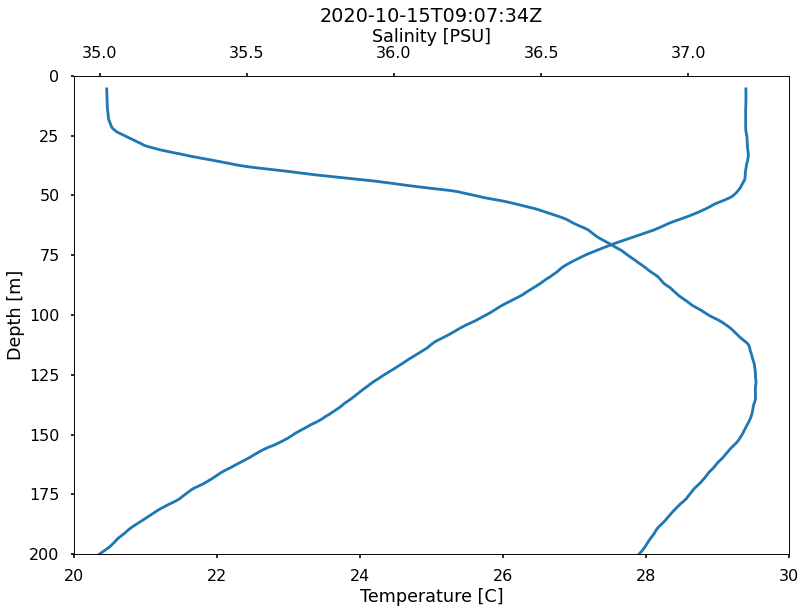

In [98]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()


ax1.plot(np.mean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth)
ax2.plot(np.mean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth)
ax1.set_ylim(200,0)
ax1.set_xlim(20,30)
ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('Temperature [C]')
ax2.set_xlabel('Salinity [PSU]')
ax1.set_title('%s'%gl_tm[tm_ind[0][0]])


## Add mean velocity to that now

In [99]:
y=7
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[y]) & (gl.end_tm.values < sect_times.endtime.values[y])]
gl_sect

,start_tm,end_tm,start_lat,start_lon,end_lat,end_lon,end_vx,end_vy
308,2020-10-15 09:56:31.907623168,2020-10-15 09:56:31.907623168,NaN,NaN,17.850142,-64.800513,-0.101187,-0.004297
309,2020-10-15 13:14:27.913940480,2020-10-15 13:14:27.913940480,NaN,NaN,17.879870,-64.803508,-0.133741,-0.006223
310,2020-10-15 16:37:21.079834112,2020-10-15 16:37:21.079834112,NaN,NaN,17.909808,-64.803287,-0.124540,0.021048
311,2020-10-15 19:56:07.751708928,2020-10-15 19:56:07.751708928,NaN,NaN,17.937273,-64.798527,-0.098883,0.002144
312,2020-10-15 23:15:44.873779200,2020-10-15 23:15:44.873779200,NaN,NaN,17.963138,-64.798580,-0.116723,-0.013080
313,2020-10-16 02:30:01.632354816,2020-10-16 02:30:01.632354816,NaN,NaN,17.987487,-64.795465,-0.119837,-0.013422
314,2020-10-16 05:44:49.512420608,2020-10-16 05:44:49.512420608,NaN,NaN,18.014355,-64.790067,-0.098321,0.005854
315,2020-10-16 08:58:31.072204544,2020-10-16 08:58:31.072204544,NaN,NaN,18.043118,-64.791250,-0.108684,-0.011559
316,2020-10-16 12:20:36.411468544,2020-10-16 12:20:36.411468544,NaN,NaN,18.071100,-64.795715,-0.142399,-0.024271
317,2020-10-16 15:34:23.425567744,2020-10-16 15:34:23.425567744,NaN,NaN,18.096282,-64.797817,-0.155180,-0.014253


/tmp/ipykernel_7081/3792357943.py:27: RuntimeWarning: Mean of empty slice
  lns3 = ax2.plot(np.nanmean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, 'k', label = 'Mean Glider Temperature')
/tmp/ipykernel_7081/3792357943.py:28: RuntimeWarning: Mean of empty slice
  lns4 = ax3.plot(np.nanmean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, '--k', label = 'Mean Glider Salinity')


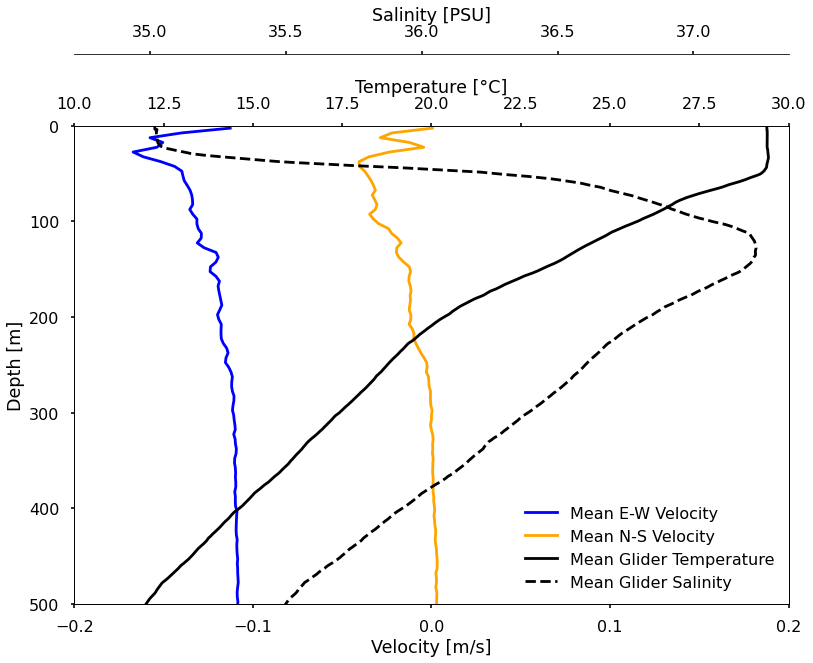

In [88]:
#y = 9 is a good one
y =7

subset = df.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[y]) & (gl.end_tm.values < sect_times.endtime.values[y])]
tm_ind = np.where((pd.to_datetime(gl_tm).tz_localize(None) >= sect_times.starttime.values[y]) & (pd.to_datetime(gl_tm).tz_localize(None) <= sect_times.endtime.values[y]))
#tm_ind

#x = 0

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
#ax4 = ax1.twiny()



lns1 = ax1.plot(np.mean(subset.inverted_u,axis=1), subset.depth, 'blue',label='Mean E-W Velocity')
lns2 = ax1.plot(np.mean(subset.inverted_v,axis=1), subset.depth, 'orange',label='Mean N-S Velocity')
ax1.set_xlabel('Velocity [m/s]')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(500,0)
ax1.set_xticks([-0.2,-0.1,0,0.1,0.2])


lns3 = ax2.plot(np.nanmean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, 'k', label = 'Mean Glider Temperature')
lns4 = ax3.plot(np.nanmean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, '--k', label = 'Mean Glider Salinity')
#lns5 = ax4.plot(np.nanmean(gl_density[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, ':k', label = 'Mean Glider Density')


ax2.set_xlim(10,30)
ax2.set_xlabel('Temperature [\N{DEGREE SIGN}C]')
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('Salinity [PSU]')
#ax4.spines.top.set_position(("axes", 1.35))
#ax4.set_xlabel('Density [kg/m$^3$]')
#ax4.set_xlim(1021.8,1028)



# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right',frameon=False)




## Load St. John Buoy Data

In [ ]:
# buoy = pd.read_fwf('/home/jg1200/Data/Buoy_Data/41052h2020.txt')
# buoy.columns = ["year", "month", "day", "hour", "minute", "WDIR", "WSPD", "GST", "WVHT", "DPD", "APD", "MWD", "PRES", "ATMP", "WTMP", "DEWP", "VIS", "TIDE"]
# buoy['time'] = pd.to_datetime(buoy[['year', 'month', 'day', 'hour', 'minute']])
# buoy

In [ ]:
# tm_ind2 = np.where((buoy.time >= sect_times.starttime.values[0]) & (buoy.time <= sect_times.endtime.values[-1]))

# plt.plot(buoy.time[tm_ind2[0]],buoy.WDIR[tm_ind2[0]])

## Test calculate Ri#


In [ ]:
mean_u = np.mean(subset.inverted_u,axis=1)
mean_v = np.mean(subset.inverted_v,axis=1)
uv_depth = subset.depth
mean_d = np.nanmean(gl_density[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1)
d_depth = gl_depth

new_mean_d = interp.griddata(d_depth, mean_d, uv_depth, method='nearest')


In [ ]:
ri = (9.81/new_mean_d[0:-1])*((np.diff(new_mean_d)/np.diff(uv_depth))/((np.diff(mean_u)/np.diff(uv_depth))*(np.diff(mean_v)/np.diff(uv_depth))))

In [ ]:
plt.plot(ri,uv_depth[0:-1])
plt.xlim(-100,100)

## This is a great way to find start and end times!!!

In [ ]:
rucool_start_times = glider_df.groupby('profile_id').first().time.values
rucool_end_times   = glider_df.groupby('profile_id').last().time.values

In [ ]:
gl_mld = np.empty(len(gl_tm))
gl_mld[:] = np.NaN

for x in np.arange(0,len(gl_tm)):
    gl_mld[x] = profile_mld(gl_density[:,x],gl_depth)


In [ ]:
gl_tm

In [ ]:
plt.pcolormesh(gl_tm,gl_depth,gl_temp)
#plt.contour(gl_tm,gl_depth,gl_density)
plt.plot(gl_tm,gl_mld,'k')
plt.gca().invert_yaxis()

In [ ]:
glider_df

In [ ]:
e = ERDDAP(server="http://slocum-data.marine.rutgers.edu/erddap")
e.constraints = None
e.protocol = "tabledap"
e.dataset_id = "ru29-20200908T1623-profile-sci-delayed"

opendap_url = e.get_download_url(
    response="opendap",
)

e.response = "nc"
e.variables = ["longitude", "latitude", "temperature", "salinity"]

ds = e.to_xarray(decode_times=False)
ds['time'] = pd.to_datetime(ds.time.values, unit='s')

ds['time'] = np.sort(ds['time'].values)

# Calculate glider density
density = gsw_rho(ds.salinity, ds.temperature, ds.depth, np.nanmean(ds.longitude), np.nanmean(ds.latitude))

ds = ds.assign(density=density)


ds

In [ ]:
mld = profile_mld(ds, mld_var='density', zvar='depth', qi_threshold=0.5)

In [ ]:
## This works but the timing is kind of weird
x=12
ind = np.where((ds.time.values >= sect_times.starttime.values[x]) & (ds.time.values <= sect_times.endtime.values[x]))

ru29_subset_temp = ds.temperature.values[ind]
ru29_subset_depth = ds.depth.values[ind]
ru29_subset_time = ds.time.values[ind]
ru29_subset_salinity = ds.salinity.values[ind]


In [ ]:
print(sect_times.starttime.values[x])
print(ru29_subset_time[0])

In [ ]:
# plt.figure(figsize=(27,10))
# plt.scatter(ds.time.values,ds.depth.values,s=50,c=ds.temperature.values)

# plt.colorbar(label='Temperature (C)', pad=0.01)
# plt.title('Temperature (°C)', fontsize = 30)
# plt.gca().invert_yaxis()
# plt.ylabel('Depth (m)', fontsize = 20)
# plt.xticks(fontsize = 20)
# plt.gca().xaxis.set_major_formatter(myFmt)
# plt.show()

In [ ]:
plt.figure(figsize=(27,10))
plt.scatter(ds.time.values,ds.depth.values,s=50,c=density)

plt.colorbar(label='Temperature (C)', pad=0.01)
plt.title('Temperature (°C)', fontsize = 30)
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [ ]:
plt.figure(figsize=(27,10))
plt.scatter(ru29_subset_time,ru29_subset_depth,s=50,c=ru29_subset_temp)

plt.colorbar(label='Temperature (C)', pad=0.01)
plt.title('Temperature (°C)', fontsize = 30)
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().xaxis.set_major_formatter(myFmtlong)
plt.show()

In [ ]:
plt.plot(ru29_subset_temp,ru29_subset_depth)
plt.plot(ru29_subset_salinity,ru29_subset_depth)
plt.ylim(100,0)

In [ ]:
plt.plot(ds.temperature.values,ds.depth.values)
plt.plot(ds.salinity.values,ds.depth.values)
plt.ylim(100,0)

### Try to load in some AMSEAS data real quick

In [ ]:
amseas_path = 'https://www.ncei.noaa.gov/thredds-coastal/dodsC/amseas/amseas_20130405_to_current/20201017/ncom_relo_amseas_u_2020101700_t000.nc'

amseas = xr.open_dataset(amseas_path, decode_times=False)
amseas
#np.max(amseas.lon-180)

In [ ]:
#amseas.water_temp[0,0,:,:].plot()

#amseas.sel(lat=slice(17,19),lon=slice(294,297))

amseas.salinity.sel(lat=slice(17,19),lon=slice(294,297),depth=0).plot()
plt.plot(gl_sect.end_lon.values+360,gl_sect.end_lat.values,'k')

In [ ]:
gl_sect.end_lon+360

## Interpolate AMSEAS to glider
https://xesmf.readthedocs.io/en/latest/notebooks/Using_LocStream.html

In [ ]:
#do a whole section

x = gl_sect.end_lon.values+360

y = gl_sect.end_lat.values

#t = xr.DataArray(section.date.values, dims="s")

# it doesn't like depth cause its not on the same dim as lon, lat, time
# you might need to make the section with model depths, then separatly interp the depths
# z = xr.DataArray(section.depth.values, dims="s")

# modsec = amseas_deployed.sel(lat=y, lon=x, time=t, method ='nearest')

# takes longer to interp, but works
test = amseas.interp(lat=y, lon=x, method ='nearest')

test
#plt.pcolormesh(test.lat.values,test.depth.values,test.water_u[0,:,:])



In [ ]:
plt.pcolormesh(test.lat, test.depth[0:33],test.water_v[0,0:33,:,5].values, vmin=-0.2,vmax=0.2,cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar()

In [ ]:
plt.pcolormesh(test.lat, test.depth[0:33],test.water_u[0,0:33,:,6].values, vmin=-0.4,vmax=0.4,cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar()

## Mike RTOFS/GOFS NetCDF

In [60]:
y=7
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[y]) & (gl.end_tm.values < sect_times.endtime.values[y])]
gl_sect.end_lon.values[0]

-64.8005133333544

In [331]:
f = '/home/jg1200/Data/Model/rtofs_20201015_20201017.nc'

ds =  xr.open_dataset(f)
ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'MT': 'time', 'Depth': 'depth'})
lat = ds.lat.data
lon = ds.lon.data

extent = [gl_sect.end_lon.values[0], gl_sect.end_lon.values[0], np.min(gl_sect.end_lat.values), np.max(gl_sect.end_lat.values)]
# extent = [western_lon, eastern_lon, southern_lat, nothern_lat]
#extent = np.add(extent, [-1, 1, -1, 1]).tolist()
#print(f'Region: {region[0]}, Extent: {extent}')

# interpolating transect X and Y to lat and lon
lonIndex = np.round(np.interp(extent[:2], lon[0, :], np.arange(0, len(lon[0, :])))).astype(int)
latIndex = np.round(np.interp(extent[2:], lat[:, 0], np.arange(0, len(lat[:, 0])))).astype(int)
sub = ds.sel(
    X=slice(lonIndex[0], lonIndex[1]),
    Y=slice(latIndex[0], latIndex[1])
)


In [333]:
sub

<xarray.Dataset>
Dimensions:      (time: 7, depth: 40, Y: 5, X: 1)
Coordinates:
  * time         (time) datetime64[ns] 2020-10-15T12:00:00 ... 2020-10-17
    Date         (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
  * depth        (depth) float32 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * Y            (Y) int32 227 228 229 230 231
  * X            (X) int32 440
    lat          (Y, X) float32 17.79 17.86 17.94 18.02 18.09
    lon          (Y, X) float32 -64.88 -64.88 -64.88 -64.88 -64.88
Data variables:
    u            (time, depth, Y, X) float32 ...
    v            (time, depth, Y, X) float32 ...
    temperature  (time, depth, Y, X) float32 ...
    salinity     (time, depth, Y, X) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       HYCOM archive file
    experiment:   92.4
    history:      archv2ncdf3z

/tmp/ipykernel_7081/2826402814.py:1: RuntimeWarning: Mean of empty slice
  mean_u = np.nanmean(sub.u.values,axis=(0,2))
/tmp/ipykernel_7081/2826402814.py:2: RuntimeWarning: Mean of empty slice
  mean_v = np.nanmean(sub.v.values,axis=(0,2))


(500.0, -5.0)

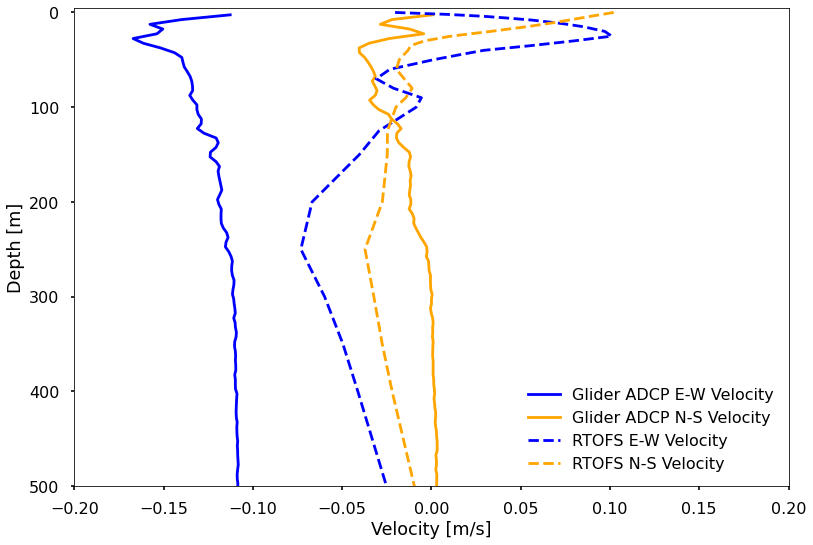

In [90]:
mean_u = np.nanmean(sub.u.values,axis=(0,2))
mean_v = np.nanmean(sub.v.values,axis=(0,2))


y =7

subset = df.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[y]) & (gl.end_tm.values < sect_times.endtime.values[y])]
tm_ind = np.where((pd.to_datetime(gl_tm).tz_localize(None) >= sect_times.starttime.values[y]) & (pd.to_datetime(gl_tm).tz_localize(None) <= sect_times.endtime.values[y]))


plt.plot(np.mean(subset.inverted_u,axis=1), subset.depth, 'blue',label='Glider ADCP E-W Velocity')
plt.plot(np.mean(subset.inverted_v,axis=1), subset.depth, 'orange',label='Glider ADCP N-S Velocity')

plt.plot(mean_u,sub.depth.values, 'blue', linestyle='dashed',label='RTOFS E-W Velocity')
plt.plot(mean_v,sub.depth.values, 'orange', linestyle='dashed',label='RTOFS N-S Velocity')
plt.legend(loc='lower right', frameon=False)
plt.xlabel('Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xlim(-0.2,0.2)
plt.ylim(500,-5)


/tmp/ipykernel_7081/1399045096.py:32: RuntimeWarning: Mean of empty slice
  lns3 = ax2.plot(np.nanmean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, 'k', label = 'Mean Glider Temperature')
/tmp/ipykernel_7081/1399045096.py:33: RuntimeWarning: Mean of empty slice
  lns4 = ax3.plot(np.nanmean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, '--k', label = 'Mean Glider Salinity')


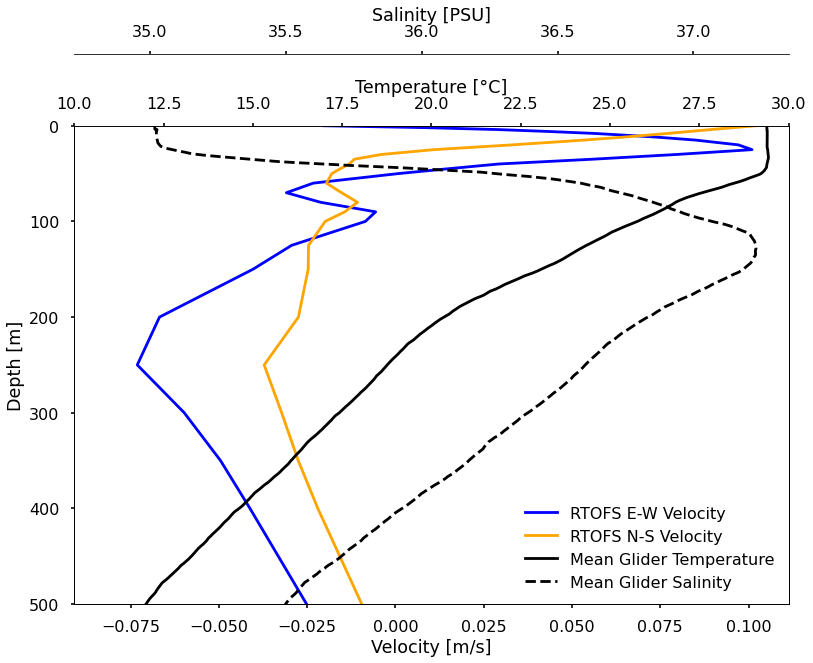

In [78]:


#y = 9 is a good one
y =7

subset = df.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[y]) & (gl.end_tm.values < sect_times.endtime.values[y])]
tm_ind = np.where((pd.to_datetime(gl_tm).tz_localize(None) >= sect_times.starttime.values[y]) & (pd.to_datetime(gl_tm).tz_localize(None) <= sect_times.endtime.values[y]))
#tm_ind

#x = 0

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
#ax4 = ax1.twiny()



#lns1 = ax1.plot(np.mean(subset.inverted_u,axis=1), subset.depth, 'blue',label='Mean E-W Velocity')
#lns2 = ax1.plot(np.mean(subset.inverted_v,axis=1), subset.depth, 'orange',label='Mean N-S Velocity')


lns1 = ax1.plot(mean_u,sub.depth.values, 'blue', label='RTOFS E-W Velocity')
lns2 = ax1.plot(mean_v,sub.depth.values, 'orange', label='RTOFS N-S Velocity')

ax1.set_xlabel('Velocity [m/s]')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(500,0)
#ax1.set_xticks([-0.15,-0.025,0,0.025,0.05])


lns3 = ax2.plot(np.nanmean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, 'k', label = 'Mean Glider Temperature')
lns4 = ax3.plot(np.nanmean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, '--k', label = 'Mean Glider Salinity')
#lns5 = ax4.plot(np.nanmean(gl_density[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, ':k', label = 'Mean Glider Density')


ax2.set_xlim(10,30)
ax2.set_xlabel('Temperature [\N{DEGREE SIGN}C]')
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('Salinity [PSU]')
#ax4.spines.top.set_position(("axes", 1.35))
#ax4.set_xlabel('Density [kg/m$^3$]')
#ax4.set_xlim(1021.8,1028)



# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right',frameon=False)



# Calculate RTOFS Transport

In [363]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(sub.lat[0])
lon1 = radians(sub.lon[0])
lat2 = radians(sub.lat[1])
lon2 = radians(sub.lon[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

transport_rtofu = np.empty(sub.u.shape[0])
transport_rtofv = np.empty(sub.u.shape[0])

for x in np.arange(0,sub.u.shape[0]):
    transport_rtofu[x] = (np.nansum(np.dot(sub.depth.values,sub.u[x,:,:,0])*distance))/(10**6)
    transport_rtofv[x] = (np.nansum(np.dot(sub.depth.values,sub.v[x,:,:,0])*distance))/(10**6) 


(7,)

In [367]:
sub.depth.values*sub.u[x,:,0,0]

<xarray.DataArray 'u' (depth: 40)>
array([ 0.        ,  0.13458906,  0.32277828,  0.5481289 ,  0.81029403,
        1.1023083 ,  1.4273182 ,  1.8630586 ,  2.3494773 ,  2.340648  ,
        2.2443354 ,  1.6210799 ,  0.37498957, -0.5345272 , -1.3367708 ,
       -2.2765927 , -3.2474308 , -3.28305   , -2.3319428 , -1.3567096 ,
        0.89674383,  4.229627  ,  0.44665286, -4.206529  ,  3.9760816 ,
        7.8993945 ,  3.5003283 , -1.4103695 , -2.4699347 , -1.8339165 ,
        1.3825437 ,  3.9484816 ,  3.0947828 , 11.192655  ,         nan,
               nan,         nan,         nan,         nan,         nan],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2020-10-17
    Date     float64 2.02e+07
  * depth    (depth) float32 0.0 2.0 4.0 6.0 8.0 ... 2.5e+03 3e+03 4e+03 5e+03
    Y        int32 227
    X        int32 440
    lat      float32 17.79
    lon      float32 -64.88
Attributes:
    standard_name:  eastward_sea_water_velocity
    units:          m/s
    valid_range:    [-1.3749415  2.6623373]
    long_name:       u-veloc. [92.4H]

In [347]:
sub

<xarray.Dataset>
Dimensions:      (time: 7, depth: 40, Y: 5, X: 1)
Coordinates:
  * time         (time) datetime64[ns] 2020-10-15T12:00:00 ... 2020-10-17
    Date         (time) float64 2.02e+07 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
  * depth        (depth) float32 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * Y            (Y) int32 227 228 229 230 231
  * X            (X) int32 440
    lat          (Y, X) float32 17.79 17.86 17.94 18.02 18.09
    lon          (Y, X) float32 -64.88 -64.88 -64.88 -64.88 -64.88
Data variables:
    u            (time, depth, Y, X) float32 -0.07281 -0.01754 ... nan nan
    v            (time, depth, Y, X) float32 0.01455 0.04772 0.083 ... nan nan
    temperature  (time, depth, Y, X) float32 29.62 29.55 29.65 ... nan nan nan
    salinity     (time, depth, Y, X) float32 34.91 34.93 34.95 ... nan nan nan
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       HYCOM archive file
    experiment:   92.4
    history:      archv2ncdf3z

In [360]:
gridvelu.shape

(201, 8, 15)